# VCD2SAIF

## vcd2saif_power
- 入力
   - 電力解析スクリプト
   - 電力レポート
- 出力
   - 電力csv

In [21]:
#ダイナミック消費電力CSVファイルを作成します
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def vcd2saif_power(power_analysis_script):
    power_analysis_script_file = open(power_analysis_script, "r")
    power_analysis_script_file_lines = power_analysis_script_file.readlines()
    time_dynamic_list = [['Time', 'Dynamic', 'LUT as Logic', 'Signals', 'LUT as Logic + Signals']]
    power_data_line = [35, 56, 63]
    n = 5
    while(n < len(power_analysis_script_file_lines)):
        power_report = power_analysis_script_file_lines[n].split('{')[1].split('}')[0]
        power_report_time = float(re.findall(r"\d+\.?\d*", power_report)[-2])
        power_report_file = open(power_report, "r")
        power_report_file_lines = power_report_file.readlines()
        power_report_dynamic = float(power_report_file_lines[power_data_line[0]].split('|')[2])
        power_report_logic = float(power_report_file_lines[power_data_line[1]].split('|')[2])
        power_report_signals = float(power_report_file_lines[power_data_line[2]].split('|')[2])
        power_report_file.close()
        time_dynamic_list.append([power_report_time, power_report_dynamic, power_report_logic, \
                                  power_report_signals, power_report_logic+power_report_signals])
        n += 2

    power_analysis_script_file.close()
    time_dynamic_df = pd.DataFrame(time_dynamic_list[1:], columns=time_dynamic_list[0])
    time_dynamic_df.set_index(time_dynamic_df.columns[0], inplace=True)
    time_dynamic_df_csv = power_analysis_script[:power_analysis_script.rfind('.')]+'_power.csv'
    time_dynamic_df.to_csv(time_dynamic_df_csv)
    print('dynamic power: %s' % time_dynamic_df_csv)
    plt.close("all")
    plt.figure()
    time_dynamic_df['Dynamic'].plot(figsize=(15, 5))
    plt.xlabel('Time (ps)')
    plt.ylabel('Power (uW)')
    plt.legend(loc='best')
    plt.xticks(rotation=45)
    plt.show()
    return time_dynamic_df

## vcd2saif_flag
- 入力
   - 電力csv
   - 回路動作時刻csv
- 出力
   - 回路動作時刻で分割した電力csv

In [22]:
import re
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt


def vcd2saif_flag(power_csv, flag_csv):
    power = pd.read_csv(power_csv, index_col=0)
    flag = pd.read_csv(flag_csv, index_col=0)
    power_flag_head = [power.index.name]
    power_flag_line_origin = [np.nan]
    for obj in flag[flag.columns[0]]:
        power_flag_head.append('{} = {}'.format(flag.columns[0], obj))
        power_flag_line_origin.append(np.nan)

    power_flag_lines = []
    power_flag_lines.append(power_flag_head)
    power_index = 0
    flag_index = 1
    power_columns = 0
    while(power_index < power.shape[0]):
        power_flag_line_output = copy.deepcopy(power_flag_line_origin)
        power_flag_line_output[0] = power.index[power_index]
        power_flag_line_output[flag_index] = power[power.columns[power_columns]][power.index[power_index]]
        if(flag_index < flag.shape[0] and power.index[power_index+1] > flag.index[flag_index]):
            flag_index += 1
            power_flag_line_output[flag_index] = power[power.columns[power_columns]][power.index[power_index]]
        power_flag_lines.append(power_flag_line_output)
        power_index += 1

    power_flag_df = pd.DataFrame(power_flag_lines[1:], columns=power_flag_lines[0])
    power_flag_df.set_index(power_flag_df.columns[0], inplace=True)
    power_flag_csv = power_csv[:power_csv.rfind('.')]+'_flag.csv'
    power_flag_df.to_csv(power_flag_csv)
    print('dynamic power flag: %s' % power_flag_csv)
    plt.close("all")
    plt.figure()
    power_flag_df.plot(figsize=(15, 5))
    plt.xlabel('Time (ps)')
    plt.ylabel('Power (uW)')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.xticks(rotation=45)
    plt.show()
    return power_flag_df

## vcd2saif_t_test_pre
- 入力
   - 電力csv
   - 回路動作時刻csv
- 出力
   - T検定用csv

In [23]:
import re
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt


def vcd2saif_t_test_pre(power_csv, flag_csv):
    power = pd.read_csv(power_csv, index_col=0)
    flag = pd.read_csv(flag_csv, index_col=0)
    power_t_test_head = [power.index.name]
    power_t_test_line_origin = [np.nan]
    for obj in flag[flag.columns[0]]:
        power_t_test_head.append('{} = {}'.format(flag.columns[0], obj))
        power_t_test_line_origin.append(np.nan)

    power_t_test_lines = []
    power_t_test_lines.append(power_t_test_head)
    power_t_test_line_index = 1
    power_t_test_line_index_max = 1
    power_columns = 0
    flag_index = 1
    power_index = 0
    while(power_index < power.shape[0]):
        if(power_t_test_line_index >= power_t_test_line_index_max):
            power_t_test_line_output = copy.deepcopy(power_t_test_line_origin)
            power_t_test_line_output[0] = power.index[0]*power_t_test_line_index
            power_t_test_line_output[flag_index] = power[power.columns[power_columns]][power.index[power_index]]
            power_t_test_line_index_max += 1
            power_t_test_lines.append(power_t_test_line_output)
        else:
            power_t_test_lines[power_t_test_line_index][flag_index] = \
            power[power.columns[power_columns]][power.index[power_index]]
        power_t_test_line_index += 1
        if(flag_index < flag.shape[0] and power.index[power_index+1] > flag.index[flag_index]):
            flag_index += 1
            power_t_test_line_index = 1
        power_index += 1

    power_t_test_df = pd.DataFrame(power_t_test_lines[1:], columns=power_t_test_lines[0])
    power_t_test_df.set_index(power_t_test_df.columns[0], inplace=True)
    power_t_test_pre_csv = power_csv[:power_csv.rfind('.')]+'_t_test_pre.csv'
    power_t_test_df.to_csv(power_t_test_pre_csv)
    print('dynamic power t test pre: %s' % power_t_test_pre_csv)
    plt.close("all")
    plt.figure()
    power_t_test_df.plot(figsize=(15, 5))
    plt.xlabel('Time (ps)')
    plt.ylabel('Power (uW)')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.xticks(rotation=45)
    plt.show()
    return power_t_test_df

## vcd2saif_t_test_value
- 入力
   - T検定用csv
- 出力
   - T値csv
   
## T検定
$$t=\frac{\overline{X_1}-\overline{X_2}}{\sqrt{\frac{s_1^2}{N_1}+\frac{s_2^2}{N_2}}}$$
- $\overline{X_1}$
   - ランダム平文暗号化消費電力の平均
- $\overline{X_2}$
   - 固定平文暗号化消費電力の平均
- $s_1$
   - ランダム平文暗号化消費電力標準偏差
- $s_2$
   - 固定平文暗号化消費電力標準偏差
- $N_1$
   - ランダム平文暗号化消費電力標本サイズ
- $N_2$
   - 固定平文暗号化消費電力標本サイズ

In [24]:
import re
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

def t_cal(set1_df, set2_df):
    x1 = set1_df.mean(axis=1)
    s1 = set1_df.std(axis=1)
    x2 = set2_df.mean(axis=1)
    s2 = set2_df.std(axis=1)
    return (x1 - x2) / np.sqrt(s1**2/(set1_df.shape[1]) + s2**2/(set2_df.shape[1]))

def vcd2saif_t_test_value(power_t_test_pre_csv):
    power = pd.read_csv(power_t_test_pre_csv, index_col=0)
    power.drop(power.columns[0:1], axis=1, inplace=True)
    head_set1 = []
    head_set2 = []
    n = int(power.shape[1]/3)
    i = 0
    while(i < n):
        head_set1.append(power.columns[i*2])
        head_set2.append(power.columns[i*2+1])
        i += 1
    
    i = 2*n
    while(i < power.shape[1]):
        head_set1.append(power.columns[i])
        i += 1

    head_set1 = head_set1[1:]
    t_test_v_df = copy.deepcopy(power.loc[:, power.columns[:0]])
    power_set1_df = copy.deepcopy(power.loc[:, head_set1])
    power_set2_df = copy.deepcopy(power.loc[:, head_set2])    
    t = []
    for obj in t_test_v_df.index:
        if power.loc[obj, np.append(head_set1, head_set2)].to_numpy().std() < 1e-9:
            t.append(list([0, 1]))
        else:
            t.append(list(ttest_ind(power_set1_df.loc[obj].to_numpy(), \
                                    power_set2_df.loc[obj].to_numpy(), equal_var = False)))
    t = np.array(t)
    t_test_v_df['Fixed vs Random'] = t[:, 0]
    t_test_v_df['Fixed vs Random p'] = t[:, 1]
#     t_test_v_df['Fixed vs Random'] = t_cal(power_set1_df, power_set2_df)
    t_test_v_csv = power_t_test_pre_csv[:power_t_test_pre_csv.rfind('_')]+'_value.csv'
    t_test_v_df = t_test_v_df[:t_test_v_df[~t_test_v_df['Fixed vs Random'].isin([np.nan])].index[-1]]
    t_test_v_df.to_csv(t_test_v_csv)
    print('dynamic power t test value: %s' % t_test_v_csv)
    plt.close("all")
    plt.figure()
    t_test_v_df['Fixed vs Random'].plot(figsize=(15, 5))
    plt.axhline(y=4.5, color='r', linestyle='-')
    plt.axhline(y=-4.5, color='r', linestyle='-')
    plt.xlabel('Time (ps)')
    plt.ylabel('T Value')
    plt.legend(loc='best')
    plt.xticks(rotation=45)
    plt.show()
    print("The count of abs(t) > 4.5: %03d" % list(t_test_v_df['Fixed vs Random'].abs()>4.5).count(True))
    plt.figure()
    power_set_df_std = copy.deepcopy(t_test_v_df.loc[:, t_test_v_df.columns[:0]])
    power_set_df_std['Random'] = power_set1_df.std(axis=1)
    power_set_df_std['Fixed'] = power_set2_df.std(axis=1)
    power_set_df_std.plot(figsize=(15, 5))
    plt.xlabel('Time (ps)')
    plt.ylabel('STD')
    plt.legend(loc='best')
    plt.xticks(rotation=45)
    plt.show()
    return t_test_v_df

dynamic power: aes_t_test_vcd2saif_power.csv


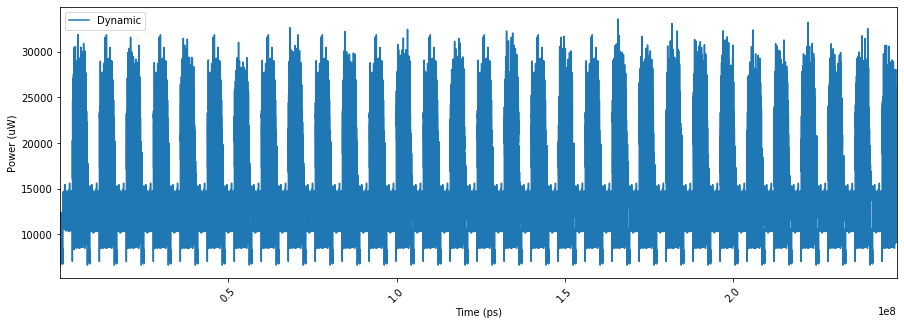

,Dynamic,LUT as Logic,Signals,LUT as Logic + Signals
Time,,,,
10000.0,7261.859,331.646,397.328,728.974
20000.0,6580.906,45.810,0.000,45.810
30000.0,6577.500,31.825,10.600,42.425
40000.0,6550.953,15.900,0.000,15.900
50000.0,6550.953,15.900,0.000,15.900
...,...,...,...,...
248670000.0,14229.672,2286.675,2872.850,5159.525
248680000.0,17518.062,3371.150,5000.550,8371.700
248690000.0,16926.266,3299.935,4499.550,7799.485


In [25]:
vcd2saif_power('aes_t_test_vcd2saif.tcl')

dynamic power flag: aes_t_test_vcd2saif_power_flag.csv


<Figure size 432x288 with 0 Axes>

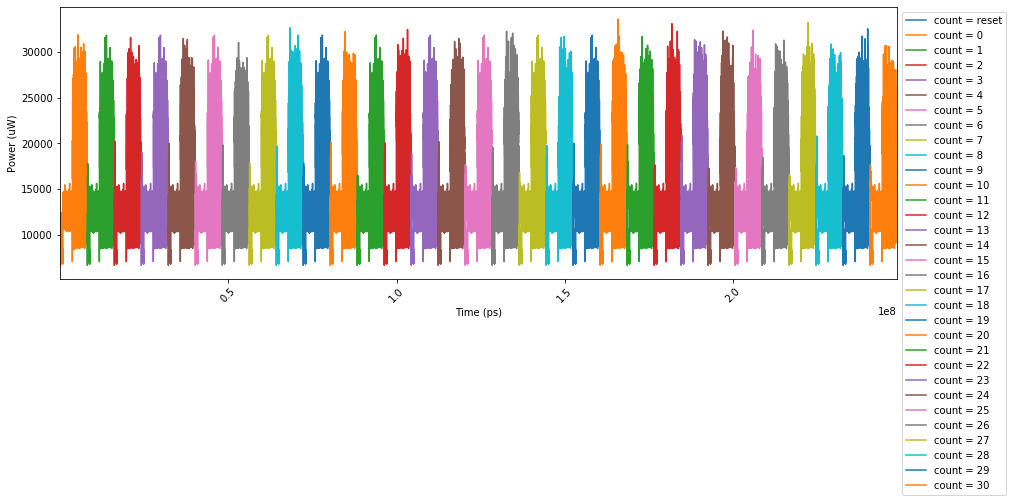

,count = reset,count = 0,count = 1,count = 2,count = 3,count = 4,count = 5,count = 6,count = 7,count = 8,...,count = 21,count = 22,count = 23,count = 24,count = 25,count = 26,count = 27,count = 28,count = 29,count = 30
Time,,,,,,,,,,,,,,,,,,,,,
10000.0,7261.859,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20000.0,6580.906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30000.0,6577.500,6577.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40000.0,NaN,6550.953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50000.0,NaN,6550.953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248670000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14229.672
248680000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17518.062
248690000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16926.266


In [26]:
vcd2saif_flag('aes_t_test_vcd2saif_power.csv', 'aes_t_test.csv')

dynamic power t test pre: aes_t_test_vcd2saif_power_t_test_pre.csv


<Figure size 432x288 with 0 Axes>

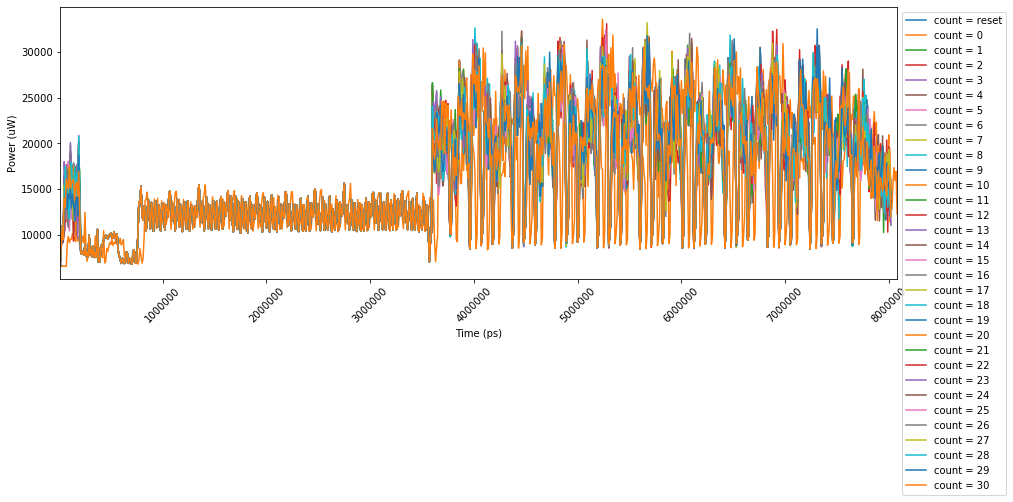

,count = reset,count = 0,count = 1,count = 2,count = 3,count = 4,count = 5,count = 6,count = 7,count = 8,...,count = 21,count = 22,count = 23,count = 24,count = 25,count = 26,count = 27,count = 28,count = 29,count = 30
Time,,,,,,,,,,,,,,,,,,,,,
10000.0,7261.859,6550.953,6639.641,6639.641,6639.641,6639.641,6639.641,6639.641,6639.641,6639.641,...,6639.641,6639.641,6639.641,6639.641,6639.641,6639.641,6639.641,6639.641,6639.641,6639.641
20000.0,6580.906,6550.953,8619.828,8619.828,8619.828,8619.828,8619.828,8619.828,8619.828,8619.828,...,8619.828,8619.828,8619.828,8619.828,8619.828,8619.828,8619.828,8619.828,8619.828,8619.828
30000.0,6577.500,6550.953,10146.688,11021.438,10682.422,10524.219,10458.875,10817.328,10550.406,10481.969,...,10373.406,10399.500,10526.672,10322.188,10494.094,10426.688,10770.156,10445.156,10553.844,10595.938
40000.0,NaN,6550.953,9227.938,9685.359,9200.109,9498.219,9226.125,9582.625,9271.891,9353.203,...,9565.906,9149.422,9759.266,9389.859,9587.719,9668.578,9616.938,9461.062,9404.875,9474.250
50000.0,NaN,6535.062,16370.906,14586.328,13946.484,14451.328,15228.688,14785.125,12687.375,14491.250,...,14261.312,10295.469,17983.094,13060.547,14118.453,14992.469,15428.141,13483.609,11927.328,13932.453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8040000.0,NaN,15378.438,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8050000.0,NaN,17336.625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8060000.0,NaN,15924.906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
vcd2saif_t_test_pre('aes_t_test_vcd2saif_power.csv', 'aes_t_test.csv')

dynamic power t test value: aes_t_test_vcd2saif_power_t_test_value.csv


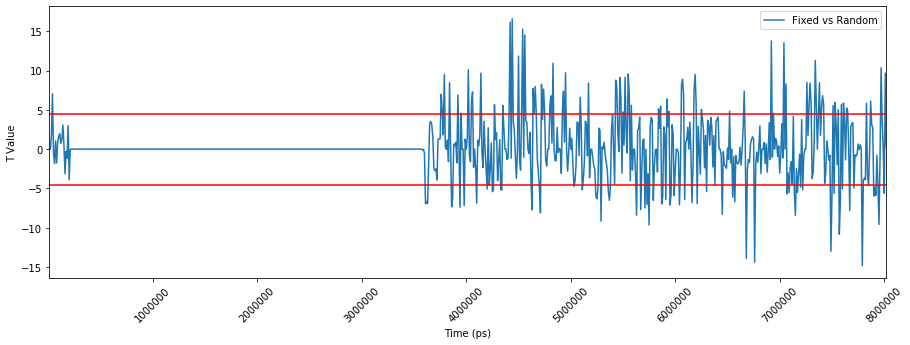

The count of abs(t) > 4.5: 154


<Figure size 432x288 with 0 Axes>

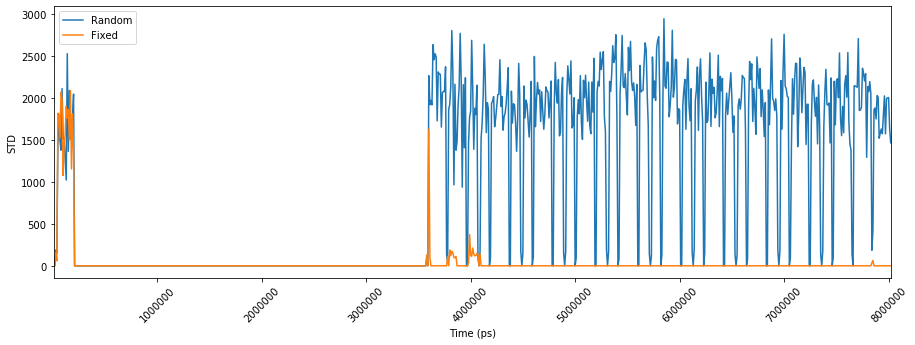

,Fixed vs Random,Fixed vs Random p
Time,,
10000.0,0.000000,1.000000e+00
20000.0,0.000000,1.000000e+00
30000.0,1.743890,9.577772e-02
40000.0,7.045427,1.432927e-07
50000.0,-0.504598,6.212171e-01
...,...,...
7980000.0,3.489694,2.452018e-03
7990000.0,0.299929,7.674876e-01
8000000.0,-5.609173,2.077790e-05


In [28]:
vcd2saif_t_test_value('aes_t_test_vcd2saif_power_t_test_pre.csv')